# IBM Advanced Data Science Capstone: Forecasting Stock Prices

## Model Training

In this project phase, We will now start building our Machine Learning and Deep Learning models to predict the highest stock price of RICs over time. As per our recommendations we will implement two algorithms: 

1. Random Forest Regression model from the machine learning stack
2. Long-Short-Term-Memory (LSTM) Recurrent Neural Network (RNN) from the deep learning stack

We will the compare the performances of the two models and do the model deployment at real-time. We will tune the hyperparameters and frequently revisit our model defintions and apply the tuning. We will also reach back to the feature engineering and multivariate analysis to update the features in order to improve the model performance. 


### Install Dependencies 

In [1]:
# find and init the spark instance to ensure it is pip installed
import findspark
findspark.init()

print("detected a spark instance!")

# set some HTML display setting 
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

print("set display settings!")
# import all the pyspark dependencies 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType, DateType
from pyspark.sql.functions import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, MinMaxScaler, RobustScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

print("installed all pyspark dependencies!")

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

print("installed all keras and tensorflow dependencies for the LSTM model!")

# declare a spark object that we will run our spark SQL dataframes on 
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

# init a spark session 
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()

print("intialized a spark context!")

# import basic data analysis libraries  
import numpy as np
import pandas as pd
import scipy.stats as stats
import random

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

print("all dependencies installed!")

detected a spark instance!


set display settings!
installed all pyspark dependencies!
installed all keras and tensorflow dependencies for the LSTM model!
intialized a spark context!
all dependencies installed!


### Import the transformed dataset

In [2]:
data_stocks_transformed = spark.read.csv('kaggle_stock_data_transformed.csv', header=True)
data_stocks_transformed = data_stocks_transformed.drop('Instrument9').withColumnRenamed('Instrument0','Instrument')
data_stocks_transformed.show(10)

+----------+----+-----+--------------+--------------+---------------+----------------+----------------+------------+--------------------+-------------------------+-------------------------+------------------------+--------------------+--------------------+-------------------------+-------------------------+------------------------+------------------+------------------+
|Instrument|Year|Month|Avg_Price_High|Avg_Price_Open|Avg_Price_Close|Avg_Daily_Return|Avg_Daily_Volume|Total_Volume| Company_Common_Name|TRBC_Economic_Sector_Name|TRBC_Business_Sector_Name|TRBC_Industry_Group_Name|  TRBC_Industry_Name|  TRBC_Activity_Name|TRBC_Economic_Sector_Code|TRBC_Business_Sector_Code|TRBC_Industry_Group_Code|TRBC_Industry_Code|TRBC_Activity_Code|
+----------+----+-----+--------------+--------------+---------------+----------------+----------------+------------+--------------------+-------------------------+-------------------------+------------------------+--------------------+--------------------+

In [3]:
# some datatype transformation may have been lost. reconfigure the dataframe accordingly and define a model set with only the required features
# once done, create a model set - i.e. the relevant features that will be used for predictive analysis 
data_stocks_modelSet = data_stocks_transformed.select("Instrument", "Year", "Month",\
"Avg_Price_Open", "Avg_Price_Close", "Avg_Price_High", "Avg_Daily_Return")

data_stocks_modelSet = data_stocks_modelSet.select(
    col("Instrument").cast(StringType()).alias("Instrument"),
    col("Year").cast(IntegerType()).alias("Year"),
    col("Month").cast(IntegerType()).alias("Month"),
    col("Avg_Price_Open").cast(DoubleType()).alias("Avg_Price_Open"),
    col("Avg_Price_Close").cast(DoubleType()).alias("Avg_Price_Close"),
    col("Avg_Price_High").cast(DoubleType()).alias("Avg_Price_High"),
    col("Avg_Daily_Return").cast(DoubleType()).alias("Avg_Daily_Return")
    
)
data_stocks_modelSet = data_stocks_modelSet.sort(['Instrument', 'Year', 'Month'], ascending=[True, True, True, True]) 
data_stocks_modelSet.dtypes

[('Instrument', 'string'),
 ('Year', 'int'),
 ('Month', 'int'),
 ('Avg_Price_Open', 'double'),
 ('Avg_Price_Close', 'double'),
 ('Avg_Price_High', 'double'),
 ('Avg_Daily_Return', 'double')]

In [4]:
data_stocks_modelSet.show(5)

+----------+----+-----+--------------+---------------+--------------+----------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|
+----------+----+-----+--------------+---------------+--------------+----------------+
|   123F.DE|2021|   11|         11.47|           11.4|         11.56|            0.07|
|   123F.DE|2021|   12|         11.85|          11.81|         11.96|            0.04|
|   123F.DE|2022|    1|         12.51|          12.55|         12.69|           -0.04|
|   123F.DE|2022|    2|         12.31|          12.25|         12.38|            0.06|
|   123F.DE|2022|    3|         11.06|           11.0|         11.13|            0.06|
+----------+----+-----+--------------+---------------+--------------+----------------+
only showing top 5 rows



## Random Forest Regression Model 

Let us now predict the average highest stock price using the Random Forest Regressor from the Machine Learning Suite. The ilustration below depicts the steps does our transformed and aggregate goes through in a Machine Learning Pipeline. 

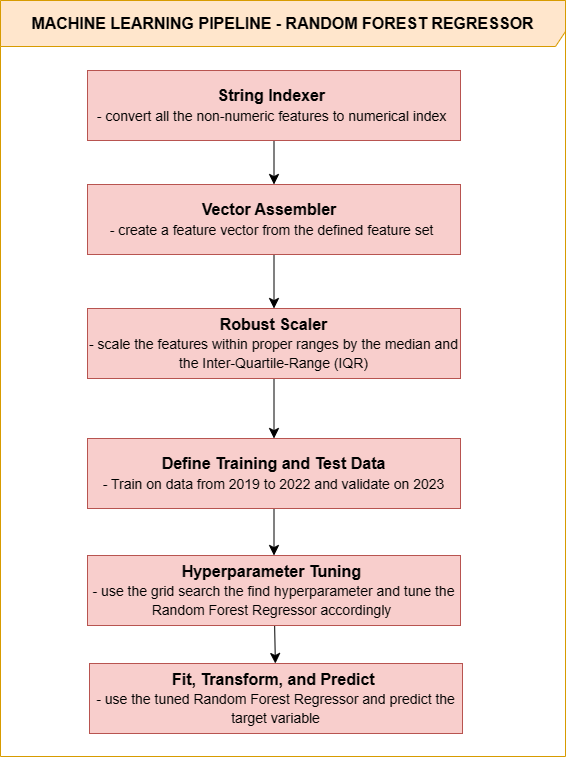

### Step-1: Build a feature vector from the feature set as defined in the Feature Engineering phase 

In [5]:
# create a VectorAssembler() object to create a feature vector from the feature set as recommended by the feature engineering
feature_cols = ['Avg_Price_Open','Avg_Price_Close', 'Avg_Daily_Return']
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="feature_vectors")
data_stocks_assembled = vector_assembler.transform(data_stocks_modelSet)
data_stocks_assembled.show(5)

+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|    feature_vectors|
+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+
|   123F.DE|2021|   11|         11.47|           11.4|         11.56|            0.07|  [11.47,11.4,0.07]|
|   123F.DE|2021|   12|         11.85|          11.81|         11.96|            0.04| [11.85,11.81,0.04]|
|   123F.DE|2022|    1|         12.51|          12.55|         12.69|           -0.04|[12.51,12.55,-0.04]|
|   123F.DE|2022|    2|         12.31|          12.25|         12.38|            0.06| [12.31,12.25,0.06]|
|   123F.DE|2022|    3|         11.06|           11.0|         11.13|            0.06|  [11.06,11.0,0.06]|
+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+
only showing top 5 rows



### Step-2: Scale the features in the feature set with the Robust Scaler 

Rationale for using the Robust Scaler: 
- Recalling the EDA, the features `Avg_Price_High` and `Avg_Price_High` were not normally distrbuted and had a lot of outliers. 
- The Standard Scaler assumes that the features are normally distrubuted whereas Min-Max Scaler is sensitive to outliers. 
- The Robust uses the Inter-Quartile Range IQR and median to scale the data and is less affected by the outliers. Hence, it is the suitable scaler for our scenario. 

In [6]:
# Standardize the features into a proper range with the robust scaler
r_scaler = RobustScaler(inputCol="feature_vectors", outputCol="scaled_features", withScaling=True, withCentering=True)
#mm_scaler1 = MinMaxScaler(inputCol='feature_vectors', outputCol='scaled_features')

scaler_model = r_scaler.fit(data_stocks_assembled)
data_stocks_featureScaled = scaler_model.transform(data_stocks_assembled)
data_stocks_featureScaled.show(5)

+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|    feature_vectors|     scaled_features|
+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+
|   123F.DE|2021|   11|         11.47|           11.4|         11.56|            0.07|  [11.47,11.4,0.07]|[-0.18528,-0.1870...|
|   123F.DE|2021|   12|         11.85|          11.81|         11.96|            0.04| [11.85,11.81,0.04]|[-0.1792000000000...|
|   123F.DE|2022|    1|         12.51|          12.55|         12.69|           -0.04|[12.51,12.55,-0.04]|[-0.16864,-0.1685...|
|   123F.DE|2022|    2|         12.31|          12.25|         12.38|            0.06| [12.31,12.25,0.06]|[-0.1718400000000...|
|   123F.DE|2022|    3|         11.06|           11.0|         11.13|            0.06|  [11.06,11.0,0.06

### Step-3: Split the data into Training and Test data

In [7]:
# Split the data into training and test sets

train_data = data_stocks_featureScaled.filter(
    (col("Year") < 2022) |
    ((col("Year") == 2022) & (col("Month") <= 9))
)

train_data = train_data.sort(['Instrument','Year','Month'], ascending=[True, True, True])

test_data = data_stocks_featureScaled.filter(
    ((col("Year") == 2022) & (col("Month") >= 9)) |
    ((col("Year") == 2023) & (col("Month") <= 9))
)
test_data = test_data.sort(['Instrument','Year','Month'], ascending=[True, True, True])

In [8]:
train_data.show()

+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|    feature_vectors|     scaled_features|
+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+
|   123F.DE|2021|   11|         11.47|           11.4|         11.56|            0.07|  [11.47,11.4,0.07]|[-0.18528,-0.1870...|
|   123F.DE|2021|   12|         11.85|          11.81|         11.96|            0.04| [11.85,11.81,0.04]|[-0.1792000000000...|
|   123F.DE|2022|    1|         12.51|          12.55|         12.69|           -0.04|[12.51,12.55,-0.04]|[-0.16864,-0.1685...|
|   123F.DE|2022|    2|         12.31|          12.25|         12.38|            0.06| [12.31,12.25,0.06]|[-0.1718400000000...|
|   123F.DE|2022|    3|         11.06|           11.0|         11.13|            0.06|  [11.06,11.0,0.06

In [9]:
test_data.show()

+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|    feature_vectors|     scaled_features|
+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+
|   123F.DE|2022|    9|          7.09|           7.06|          7.13|            0.02|   [7.09,7.06,0.02]|[-0.2553600000000...|
|   123F.DE|2022|   10|          6.69|           6.67|          6.77|            0.02|   [6.69,6.67,0.02]|[-0.26176,-0.2628...|
|   123F.DE|2022|   11|           6.4|           6.25|          6.42|            0.14|    [6.4,6.25,0.14]|[-0.2663999999999...|
|   123F.DE|2022|   12|          5.81|           5.88|          5.96|           -0.06|  [5.81,5.88,-0.06]|[-0.2758400000000...|
|   123F.DE|2023|    1|          5.52|           5.66|          5.81|           -0.14|  [5.52,5.66,-0.14

### Step-4: Hyperparameter Tuning

In [10]:
''' 
find_hyperparameters() : a function to find the hyperparameter for the Random Forest Regressor usinf the grid search method 
@params: df - an input dataframe, featuresCol - column in the dataframe that has the scaled feature vectors, labelCol - column of the target variable, 
              num_trees_array - an array with some no. of tree for which we are tuning the regressor, num_iterations - how many times to run the search
@return: None 
'''
def find_hyperparameters(df, featuresCol, labelCol, num_trees_array, num_iterations): 
    
    rf_init = RandomForestRegressor(featuresCol=featuresCol, labelCol=labelCol, seed=42)
    
    param_grid = ParamGridBuilder() \
    .addGrid(rf_init.numTrees, random.sample(num_trees_array, num_iterations)) \
    .build()

    evaluator = RegressionEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="rmse")

    tvs = TrainValidationSplit(estimator=rf_init,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           trainRatio=0.8,
                           seed=42)

    tvs_model = tvs.fit(df)

    # Get the best model and its hyperparameters
    best_model = tvs_model.bestModel
    best_num_trees = best_model.getNumTrees
    
    print(best_model)
    print(best_num_trees)

print("find_hyperparameters() compiled ...")

find_hyperparameters() compiled ...


In [11]:
# uncomment this line to find the number of tree in the random forest, i already compiled it and got 32 
#find_hyperparameters(train_data, 'scaled_features', 'Avg_Price_High', [16, 32, 64, 128], 3)

### Step-5: Tune the Regressor based on the searched Hyperparameter and predict the target 

In [12]:
# define the regression models for each target feature, tune the hyperparameters based on the findings, keep retuning them  
rf_tuned = RandomForestRegressor(featuresCol="scaled_features", labelCol="Avg_Price_High", numTrees=16, seed=42)

In [13]:
# fit the model on the training data 
rf_model = rf_tuned.fit(train_data)

In [14]:
# Predict the Avg_Price_High on the test data 
predictions_test = rf_model.transform(test_data).withColumnRenamed("prediction", "Predicted_Avg_Price_High")
predictions_test.show(10)

+----------+----+-----+--------------+---------------+--------------+----------------+-----------------+--------------------+------------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|  feature_vectors|     scaled_features|Predicted_Avg_Price_High|
+----------+----+-----+--------------+---------------+--------------+----------------+-----------------+--------------------+------------------------+
|   123F.DE|2022|    9|          7.09|           7.06|          7.13|            0.02| [7.09,7.06,0.02]|[-0.2553600000000...|      13.041857552447697|
|   123F.DE|2022|   10|          6.69|           6.67|          6.77|            0.02| [6.69,6.67,0.02]|[-0.26176,-0.2628...|      13.041857552447697|
|   123F.DE|2022|   11|           6.4|           6.25|          6.42|            0.14|  [6.4,6.25,0.14]|[-0.2663999999999...|      16.403270711496326|
|   123F.DE|2022|   12|          5.81|           5.88|          5.96|           -0.06|[5.81,5.

In [15]:
# Predict the Avg_Price_High on the traning data as well - to check for overfitting/underfitting later on  
predictions_train = rf_model.transform(train_data).withColumnRenamed("prediction", "Predicted_Avg_Price_High")
predictions_train.show(10)

+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+------------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|    feature_vectors|     scaled_features|Predicted_Avg_Price_High|
+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+------------------------+
|   123F.DE|2021|   11|         11.47|           11.4|         11.56|            0.07|  [11.47,11.4,0.07]|[-0.18528,-0.1870...|       17.59109662829368|
|   123F.DE|2021|   12|         11.85|          11.81|         11.96|            0.04| [11.85,11.81,0.04]|[-0.1792000000000...|      16.498389900611677|
|   123F.DE|2022|    1|         12.51|          12.55|         12.69|           -0.04|[12.51,12.55,-0.04]|[-0.16864,-0.1685...|      16.498389900611677|
|   123F.DE|2022|    2|         12.31|          12.25|         12.38|            0

### Step-6 : Performance Evaluation of the Random Forest Regressor

In [16]:
''' 
@evaluate_RMSE(): function to calculate the Root-Mean-Sqaured-Error or RMSE between actual and predicted values 
@params: labelCol - column containing actual values, predictionCol - column containing predicted values, df - input dataframe 
@return: None 
'''
def evaulate_RMSE(labelCol, predictionCol, df):
    evaluator_rmse = RegressionEvaluator(labelCol=labelCol, predictionCol=predictionCol, metricName='rmse')
    rmse = evaluator_rmse.evaluate(df)
    print("RMSE for " + predictionCol)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("\n")

print('function evaluate_RMSE() compiled ...')
''' 
@evaluate_R2(): function to calculate the R2 measure and determine how much variance has been explained by the model  
@params: labelCol - column containing actual values, predictionCol - column containing predicted values, df - input dataframe 
@return: None 
'''
def evaluate_R2(labelCol, predictionCol, df):
    evaluator_r2 = RegressionEvaluator(labelCol=labelCol, predictionCol=predictionCol, metricName='r2')
    r2 = evaluator_r2.evaluate(df)
    print("R-squared measure for " + predictionCol)
    print(f"R-squared (R2): {r2}")
    print("\n")

print('function evaluate_R2() compiled ...')

function evaluate_RMSE() compiled ...
function evaluate_R2() compiled ...


#### Test Data : January 2023 to September 2023

In [17]:
evaulate_RMSE("Avg_Price_High", "Predicted_Avg_Price_High", predictions_test)
evaluate_R2("Avg_Price_High", "Predicted_Avg_Price_High", predictions_test)

# Calculate MAE (Mean Absolute Error)
predictions_test = predictions_test.withColumn("MAE", abs(col("Avg_Price_High") - col("Predicted_Avg_Price_High")))

predictions_test = predictions_test.withColumn(
    "MAPE",
    (abs((col("Avg_Price_High") - col("Predicted_Avg_Price_High")) / col("Avg_Price_High"))) * 100
)

avg_mae = predictions_test.selectExpr("avg(MAE)").first()[0]
avg_mape = predictions_test.selectExpr("avg(MAPE)").first()[0]



print("Mean Absolute Error (MAE) measure for Avg_Price_High")
print(f" MAE : {avg_mae}")
print("\n")

print("Mean Absolute Percentage Error (MAPE) measure for Avg_Price_High")
print(f"MAPE : {avg_mape}")
print("\n")


RMSE for Predicted_Avg_Price_High
Root Mean Squared Error (RMSE): 114.89251668676106


R-squared measure for Predicted_Avg_Price_High
R-squared (R2): 0.7968220127212097


Mean Absolute Error (MAE) measure for Avg_Price_High
 MAE : 27.1127356587474


Mean Absolute Percentage Error (MAPE) measure for Avg_Price_High
MAPE : 1259.8859575808976




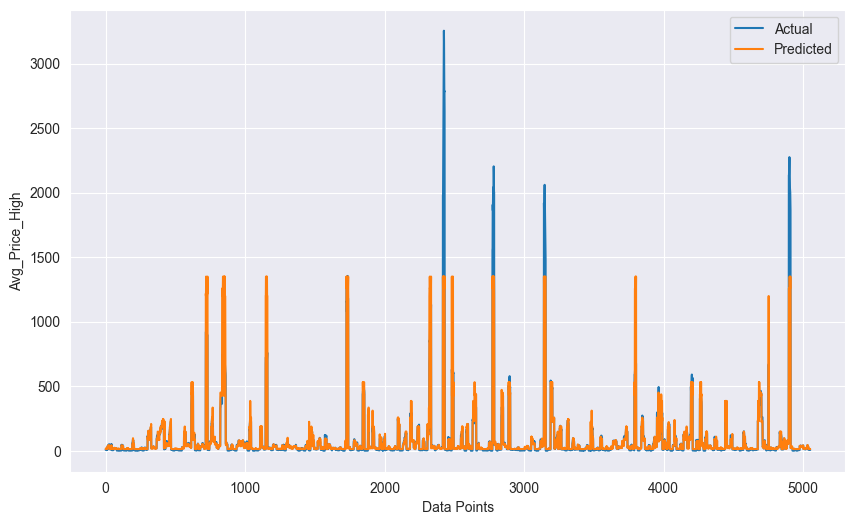

In [18]:
# Plot actual vs. predicted values
# Extract actual and predicted values
actual_values = predictions_test.select("Avg_Price_High").rdd.map(lambda row: row[0]).collect()
predicted_values = predictions_test.select("Predicted_Avg_Price_High").rdd.map(lambda row: row[0]).collect()

plt.figure(figsize=(10, 6))
plt.plot(actual_values, label="Actual")
plt.plot(predicted_values, label="Predicted")
plt.xlabel("Data Points")
plt.ylabel("Avg_Price_High")
plt.legend()
plt.show()

#### Training Data : January 2019 to December 2022

In [19]:
evaulate_RMSE("Avg_Price_High", "Predicted_Avg_Price_High", predictions_train)
evaluate_R2("Avg_Price_High", "Predicted_Avg_Price_High", predictions_train)

# Calculate MAE (Mean Absolute Error)
predictions_train = predictions_train.withColumn("MAE", abs(col("Avg_Price_High") - col("Predicted_Avg_Price_High")))

predictions_train = predictions_train.withColumn(
    "MAPE",
    (abs((col("Avg_Price_High") - col("Predicted_Avg_Price_High")) / col("Avg_Price_High"))) * 100
)


avg_mae_train = predictions_train.selectExpr("avg(MAE)").first()[0]
avg_mape_train = predictions_train.selectExpr("avg(MAPE)").first()[0]


print("Mean Absolute Error (MAE) measure for Avg_Price_High")
print(f" MAE : {avg_mae_train}")
print("\n")

print("Mean Absolute Percentage Error (MAPE) measure for Avg_Price_High")
print(f"MAPE : {avg_mape_train}")
print("\n")


RMSE for Predicted_Avg_Price_High
Root Mean Squared Error (RMSE): 126.30014478061727


R-squared measure for Predicted_Avg_Price_High
R-squared (R2): 0.7842756458431276


Mean Absolute Error (MAE) measure for Avg_Price_High
 MAE : 28.96856599341807


Mean Absolute Percentage Error (MAPE) measure for Avg_Price_High
MAPE : 585.0506801609278




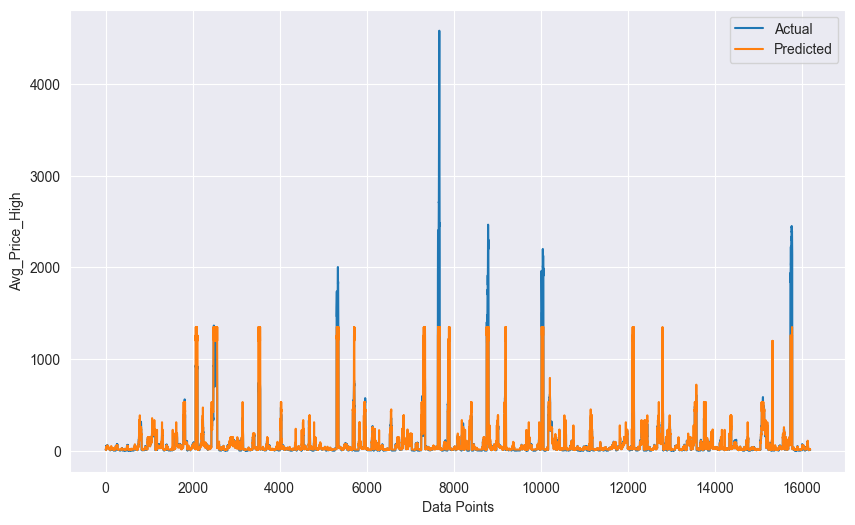

In [20]:
# Plot actual vs. predicted values
# Extract actual and predicted values
actual_values_train = predictions_train.select("Avg_Price_High").rdd.map(lambda row: row[0]).collect()
predicted_values_train = predictions_train.select("Predicted_Avg_Price_High").rdd.map(lambda row: row[0]).collect()

plt.figure(figsize=(10, 6))
plt.plot(actual_values_train, label="Actual")
plt.plot(predicted_values_train, label="Predicted")
plt.xlabel("Data Points")
plt.ylabel("Avg_Price_High")
plt.legend()
plt.show()

### Observations: 
- The performance of the Random Forest Regressor is very similar on both training and test data.
- Different Regression Testing measures like RMSE, R2, MAE and MAPE are similar for training and test sets.
- So, we can conclude that there is no overfitting or underfitting based on our current setup.
- While the R2 is pretty good, explaining about 92% of the variance, RMSE, MAE and MAPE are very high, which means there is a large difference between the actual and predicted `Avg_Price_High`. 
- We will record these regression test results and later compare them with the LSTM model from the Deep Learning Stack.  

## LSTM RNN Model

Now that we have built the Random Forest Regressor from the Machine Learning stack and recorded its performance measure, we will now built a Long-Short-Term-Memory from the Deep Learning Stack. LSTM is a Recurrent-Neural-Network model that is known for sequential time-series prediction. As the name suggests, it captures short term memory of a traditional RNN and repeats it step over step for a longer time period. 

Since, we have already encoded numeric indexes, created feature vectors and scale features in the Random Forest Pipeline, we will reuse the instance as these are the same steps in the LSTM pipeline as well. 

So, our step-1 for LSTM continues from the Standard Scaler step of the Random Forest Pipeline. 


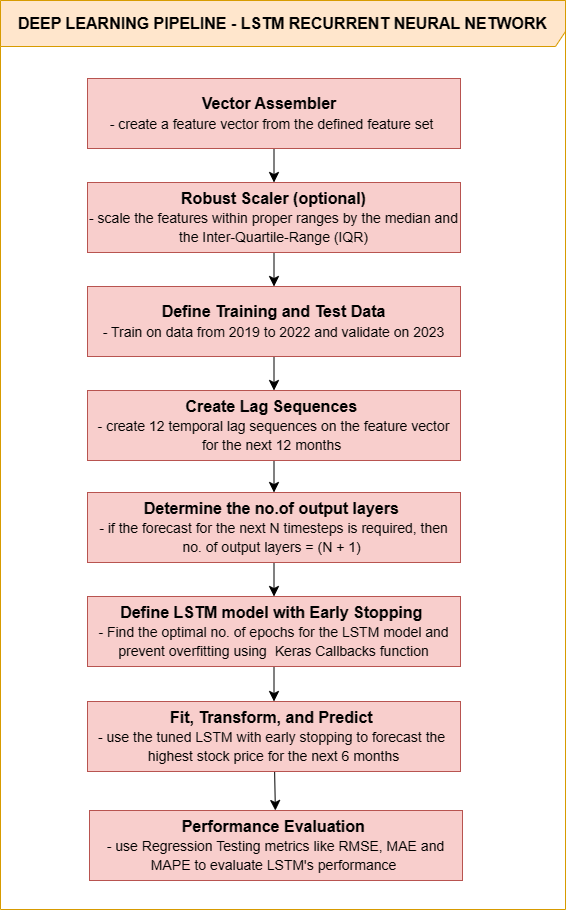

In [21]:
data_stocks_featureScaled.show(5)

+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|    feature_vectors|     scaled_features|
+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+
|   123F.DE|2021|   11|         11.47|           11.4|         11.56|            0.07|  [11.47,11.4,0.07]|[-0.18528,-0.1870...|
|   123F.DE|2021|   12|         11.85|          11.81|         11.96|            0.04| [11.85,11.81,0.04]|[-0.1792000000000...|
|   123F.DE|2022|    1|         12.51|          12.55|         12.69|           -0.04|[12.51,12.55,-0.04]|[-0.16864,-0.1685...|
|   123F.DE|2022|    2|         12.31|          12.25|         12.38|            0.06| [12.31,12.25,0.06]|[-0.1718400000000...|
|   123F.DE|2022|    3|         11.06|           11.0|         11.13|            0.06|  [11.06,11.0,0.06

### Step-1: Create lagging sequences based on the Scaled Features

In [22]:
# Define the sequence length
from pyspark.sql.window import Window

# we define a sequence length of 12 - for every month in a year 
sequence_length = 12

# Use Window function to create sequences
window_spec = Window.partitionBy("Instrument").orderBy("Year", "Month")
for i in range(1, sequence_length + 1):
    lag_col = "lag_{}".format(i)
    data_stocks_featureScaled = data_stocks_featureScaled.withColumn(lag_col, lag(data_stocks_featureScaled["scaled_features"], i).over(window_spec))

In [23]:
data_stocks_featureScaled.show(20)

+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|    feature_vectors|     scaled_features|               lag_1|               lag_2|               lag_3|               lag_4|               lag_5|               lag_6|               lag_7|               lag_8|               lag_9|              lag_10|              lag_11|              lag_12|
+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------

In [24]:
data_stocks_featureScaled = data_stocks_featureScaled.dropna()

In [25]:
data_stocks_featureScaled.show(20)

+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|    feature_vectors|     scaled_features|               lag_1|               lag_2|               lag_3|               lag_4|               lag_5|               lag_6|               lag_7|               lag_8|               lag_9|              lag_10|              lag_11|              lag_12|
+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------

### Step-2: Create Training and Testing Data 

In [26]:
''' 
We will keep consistency with the same configuration we used for the Random Forest to avoid any model bias 
So, Training Data : January 2019 to September 2022
and Test Data : October 2023 to September 2023
'''
# train_data_new = data_stocks_featureScaled.filter(data_stocks_featureScaled.Year < 2023)
# test_data_new = data_stocks_featureScaled.filter(data_stocks_featureScaled.Year == 2023)

# Split the data into training and test sets

train_data_new = data_stocks_featureScaled.filter(
    (col("Year") < 2022) |
    ((col("Year") == 2022) & (col("Month") <= 9))
)

train_data_new = train_data_new.sort(['Instrument','Year','Month'], ascending=[True, True, True])

test_data_new = data_stocks_featureScaled.filter(
    ((col("Year") == 2022) & (col("Month") >= 9)) |
    ((col("Year") == 2023) & (col("Month") <= 9))
)
test_data_new = test_data_new.sort(['Instrument','Year','Month'], ascending=[True, True, True])

X_train = np.array(train_data_new.select(["lag_{}".format(i) for i in range(1, sequence_length + 1)]).collect())
y_train = np.array(train_data_new.select("Avg_Price_High").collect())
X_test = np.array(test_data_new.select(["lag_{}".format(i) for i in range(1, sequence_length + 1)]).collect())
y_test = np.array(test_data_new.select("Avg_Price_High").collect())



### Step-3: Build and compile the LSTM Model with Keras  

In [27]:
'''
define the model with standard configurations and set the input_shape to the sequence length of 12, in line with the prediction sequences 
since, we are predicting the current Avg_Price_High and 6 months from then on. So number of output layer will be 1 + 6 = 7   
'''
#model = keras.Sequential()
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, activation='relu', input_shape=(sequence_length, len(feature_cols))))
model.add(keras.layers.Dense(7))  # Output layer for regression


In [28]:
# compile the model with MSE as the loss function i.e. it calculates the loss between actual and predicted in terms of MSE 
model.compile(optimizer='adam', loss='mean_squared_error')

### Step-4: Find the right number of Epoch to prevent overfitting

Epoch 1/1000
90/90 [==============================] - 5s 17ms/step - loss: 48702.2109 - val_loss: 3597.0317
Epoch 2/1000
90/90 [==============================] - 1s 11ms/step - loss: 2094.0369 - val_loss: 1822.8190
Epoch 3/1000
90/90 [==============================] - 1s 11ms/step - loss: 1158.8655 - val_loss: 995.4684
Epoch 4/1000
90/90 [==============================] - 1s 12ms/step - loss: 893.4907 - val_loss: 813.7406
Epoch 5/1000
90/90 [==============================] - 1s 11ms/step - loss: 966.3564 - val_loss: 1147.3082
Epoch 6/1000
90/90 [==============================] - 1s 11ms/step - loss: 851.5311 - val_loss: 726.5677
Epoch 7/1000
90/90 [==============================] - 1s 14ms/step - loss: 954.9411 - val_loss: 928.8112
Epoch 8/1000
90/90 [==============================] - 1s 12ms/step - loss: 1089.5958 - val_loss: 1268.3657
Epoch 9/1000
90/90 [==============================] - 1s 13ms/step - loss: 683.1871 - val_loss: 669.6551
Epoch 10/1000
90/90 [=========================

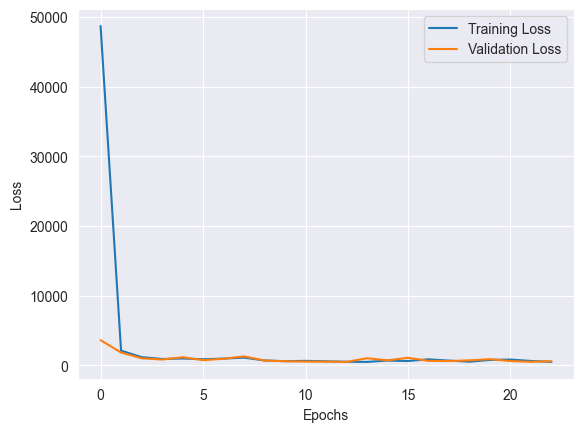

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

from keras import callbacks
# Early stopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="auto", patience=10,
                                        restore_best_weights=True)

# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, callbacks=[early_stopping], verbose=1)

history = model.fit(X_train, y_train, batch_size=128,
                    epochs=1000, validation_data=(X_test, y_test),
                    callbacks=[earlystopping])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Step-4: Fit the LSTM model on the training and predict on the test data  

In [30]:
# predict on the test set 
test_predictions = model.predict(X_test)

155/155 [==============================] - 1s 3ms/step


In [31]:
test_predictions

array([[6.5376635, 5.336699 , 5.9933076, ..., 4.926352 , 6.194905 ,
        6.696096 ],
       [5.8439126, 4.681413 , 5.280206 , ..., 4.3628583, 5.5136256,
        5.947399 ],
       [5.979367 , 4.7441707, 5.3604026, ..., 4.5134816, 5.6322994,
        6.072167 ],
       ...,
       [6.818358 , 5.2869735, 5.9493623, ..., 5.107081 , 6.4125175,
        6.8284526],
       [6.5152574, 5.131435 , 5.799334 , ..., 4.824641 , 6.162496 ,
        6.566692 ],
       [5.8762765, 4.5448136, 5.1367664, ..., 4.26508  , 5.53338  ,
        5.892357 ]], dtype=float32)

In [32]:
# create a copy of the test data on which prediction is to be performed
test_data_new_copy = test_data_new.select("*")

In [33]:
# save the predictions in a temporary dataframe to be joined back into the test data 
spark_df = spark.createDataFrame(test_predictions.tolist(), ["Predicted_Avg_Price_High"])

In [34]:
# add an 'index' column to predictions dataframe and the test data 
spark_df = spark_df.withColumn("index", monotonically_increasing_id())
test_data_new_copy = test_data_new_copy.withColumn("index", monotonically_increasing_id())

In [35]:
# Join the two DataFrames on the index column and now drop it - the resultant dataframe is better organized now 
lstm_predictions = test_data_new_copy.join(spark_df, on="index").drop("index")
lstm_predictions.show(15)

+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|    feature_vectors|     scaled_features|               lag_1|               lag_2|               lag_3|               lag_4|               lag_5|               lag_6|               lag_7|               lag_8|               lag_9|              lag_10|              lag_11|              lag_12|Predicted_Avg_Price_High|                _2|                _3|                _4|                _5| 

### Step-5: Performance Evaluation of LSTM 

In [36]:
# 7. Evaluate the model
mae = np.mean(np.abs(test_predictions - y_test))
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 6.373763567415505


In [37]:
# Calculate the absolute percentage errors
absolute_percentage_errors = np.abs((test_predictions - y_test) / test_predictions)
# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(absolute_percentage_errors) * 100
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

# Calculate the squared differences
squared_diff = (test_predictions - y_test) ** 2
# Calculate the mean of squared differences
mse = np.mean(squared_diff)
# Calculate RMSE by taking the square root of MSE
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Percentage Error (MAPE): 21.152796576071932 %
Root Mean Square Error (RMSE): 21.766467745675456


### Step-6: Comparing the Performance of Random Forest versus LSTM 

Now, we we have implemented both models from the Machine Learning and Deep Learning stack, it is now time compare their performane based on the Regression Testing results: 

- **RMSE:** The RMSE for Random Forest is 80.23 and for LSTM it is 21.54. It means the euclidean distance between actual and predicted values is almost 4 times higher in Random Forest than LSTM.
- **MAE:** The Mean-Absolute Error for Random Forest is 17.34 and for LSTM it is 6.87. It means the error between actual and predicted values is almost more than twice higher in Random Forest than LSTM.
- **MAPE:** The Mean-Absolute-Percentage-Error for Random Forest in extremely high 317.7% and for LSTM it is only 28.67%. MAPE is measure highly sensitive to outliers and we saw that the dataset had a outliers in the EDA. This further negatively impacts the Performance of the Random Forest or any regression model when it comes to time-series or sequential forecasting.

Based on the Regression Testing, it is clear that the LSTM model from the Deep Learning Stack is the superior model when it comes to predicting highest stock price. It also validates a conception that Regression models are not well-suited for time-series problems as we can notice how much error it generates. 

The final step is the deployment. We will deploy the LSTM model and make real-time forecast of highest stock prices through an API service. 

## Validation and Deployment 

We will test and validate the LSTM model on a specific RIC and will devise the deployment recommendations based on that. 

In [38]:
# recall the transformed from the ETL part - this is where we will find the RIC
data_stocks_transformed.show(10)

+----------+----+-----+--------------+--------------+---------------+----------------+----------------+------------+--------------------+-------------------------+-------------------------+------------------------+--------------------+--------------------+-------------------------+-------------------------+------------------------+------------------+------------------+
|Instrument|Year|Month|Avg_Price_High|Avg_Price_Open|Avg_Price_Close|Avg_Daily_Return|Avg_Daily_Volume|Total_Volume| Company_Common_Name|TRBC_Economic_Sector_Name|TRBC_Business_Sector_Name|TRBC_Industry_Group_Name|  TRBC_Industry_Name|  TRBC_Activity_Name|TRBC_Economic_Sector_Code|TRBC_Business_Sector_Code|TRBC_Industry_Group_Code|TRBC_Industry_Code|TRBC_Activity_Code|
+----------+----+-----+--------------+--------------+---------------+----------------+----------------+------------+--------------------+-------------------------+-------------------------+------------------------+--------------------+--------------------+

In [39]:
# apply the neccessary transformations - filter out for a given RIC and the last 12 months historical data 
data_val = data_stocks_transformed.drop('Instrument9').withColumnRenamed('Instrument0','Instrument')

data_val_modelSet = data_val.select(
    col("Instrument").cast(StringType()).alias("Instrument"),
    col("Year").cast(IntegerType()).alias("Year"),
    col("Month").cast(IntegerType()).alias("Month"),
    col("Avg_Price_Open").cast(DoubleType()).alias("Avg_Price_Open"),
    col("Avg_Price_Close").cast(DoubleType()).alias("Avg_Price_Close"),
    col("Avg_Price_High").cast(DoubleType()).alias("Avg_Price_High"),
    col("Avg_Daily_Return").cast(DoubleType()).alias("Avg_Daily_Return")
).filter(col('Instrument') == '1COV.DE').sort(['Year','Month'])

data_val_modelSet = data_val_modelSet.filter(
    ((col("Year") == 2022) & (col("Month") >= 9)) |
    ((col("Year") == 2023) & (col("Month") <= 9))
).sort('Year','Month')
data_val_modelSet
data_val_modelSet.show()

+----------+----+-----+--------------+---------------+--------------+----------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|
+----------+----+-----+--------------+---------------+--------------+----------------+
|   1COV.DE|2022|    9|          30.0|          30.07|         30.53|           -0.07|
|   1COV.DE|2022|   10|         33.39|          33.63|         34.23|           -0.25|
|   1COV.DE|2022|   11|         36.09|          36.19|         36.82|            -0.1|
|   1COV.DE|2022|   12|         36.65|          36.62|         37.05|            0.03|
|   1COV.DE|2023|    1|         41.24|          41.46|         41.91|           -0.22|
|   1COV.DE|2023|    2|          42.2|          42.12|          42.7|            0.09|
|   1COV.DE|2023|    3|         38.15|          38.01|         38.61|            0.14|
|   1COV.DE|2023|    4|          37.1|          37.16|         37.65|           -0.07|
|   1COV.DE|2023|    5|         39.22|     

In [40]:
# repeat the pipeline stages - starting with feature vectors
data_val_assembled = vector_assembler.transform(data_val_modelSet)
data_val_assembled.show()

+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|    feature_vectors|
+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+
|   1COV.DE|2022|    9|          30.0|          30.07|         30.53|           -0.07| [30.0,30.07,-0.07]|
|   1COV.DE|2022|   10|         33.39|          33.63|         34.23|           -0.25|[33.39,33.63,-0.25]|
|   1COV.DE|2022|   11|         36.09|          36.19|         36.82|            -0.1| [36.09,36.19,-0.1]|
|   1COV.DE|2022|   12|         36.65|          36.62|         37.05|            0.03| [36.65,36.62,0.03]|
|   1COV.DE|2023|    1|         41.24|          41.46|         41.91|           -0.22|[41.24,41.46,-0.22]|
|   1COV.DE|2023|    2|          42.2|          42.12|          42.7|            0.09|  [42.2,42.12,0.09]|
|   1COV.DE|2023|    3|         38.15

In [41]:
# next scale the features with the robust scaler 
data_val_featureScaled = r_scaler.fit(data_val_assembled).transform(data_val_assembled)
data_val_featureScaled.show()

+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|    feature_vectors|     scaled_features|
+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+
|   1COV.DE|2022|    9|          30.0|          30.07|         30.53|           -0.07| [30.0,30.07,-0.07]|[-1.6147110332749...|
|   1COV.DE|2022|   10|         33.39|          33.63|         34.23|           -0.25|[33.39,33.63,-0.25]|[-1.0210157618213...|
|   1COV.DE|2022|   11|         36.09|          36.19|         36.82|            -0.1| [36.09,36.19,-0.1]|[-0.5481611208406...|
|   1COV.DE|2022|   12|         36.65|          36.62|         37.05|            0.03| [36.65,36.62,0.03]|[-0.4500875656742...|
|   1COV.DE|2023|    1|         41.24|          41.46|         41.91|           -0.22|[41.24,41.46,-0.22

In [42]:
# we define a sequence length of 12 - for every month in a year 
sequence_length = 12

# Use Window function to create sequences
w1 = Window.partitionBy("Instrument").orderBy("Year", "Month")
for i in range(1, sequence_length + 1):
    lag_col = "lag_{}".format(i)
    data_val_featureScaled = data_val_featureScaled.withColumn(lag_col, lag(data_val_featureScaled["feature_vectors"], i).over(w1))

data_val_featureScaled.show()

+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|    feature_vectors|     scaled_features|              lag_1|              lag_2|              lag_3|              lag_4|              lag_5|              lag_6|              lag_7|              lag_8|              lag_9|             lag_10|             lag_11|            lag_12|
+----------+----+-----+--------------+---------------+--------------+----------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------

In [43]:
# take the most recent month data - because this is starting point for the next 6 months 
data_last = data_val_featureScaled.filter((col('Year')==2023) & (col('Month')==9))
data_last.show()

+----------+----+-----+--------------+---------------+--------------+----------------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+
|Instrument|Year|Month|Avg_Price_Open|Avg_Price_Close|Avg_Price_High|Avg_Daily_Return|   feature_vectors|     scaled_features|              lag_1|              lag_2|              lag_3|             lag_4|             lag_5|             lag_6|            lag_7|              lag_8|             lag_9|            lag_10|             lag_11|            lag_12|
+----------+----+-----+--------------+---------------+--------------+----------------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-----------------+-------------------+-

In [44]:
X_val = np.array(data_last.select(["lag_{}".format(i) for i in range(1, sequence_length+1)]).collect())

In [45]:
# perform the prediction 
next_6_months_predictions = model.predict(X_val)

1/1 [==============================] - 0s 29ms/step


In [46]:
next_6_months_predictions.tolist()[0]

[2870.880859375,
 2842.33349609375,
 2892.90234375,
 2949.721923828125,
 2910.457763671875,
 2876.945068359375,
 2939.540771484375]

In [47]:
# save the model to a h5 file 
#model.save('LSTM_model_build_v1.h5')

### Deployment Recommendations

- Build a web service that takes a RIC or instrument code as a form input
- Take the transformed dataframe as an input dataframe and filter the RIC on it 
- Implement the validation steps and apply the pipelines stages on the RIC data
- Preload the LSTM model and predict for the next 6 months for that RIC
- Create a nice visualization like a seaborn line plot and visualize the forecasts 